In [1]:
import numpy as np
from functools import partial
import PIL.Image
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
content_image = 'data/gulli.jpg'
# start with a gray image with a little noise
img_noise = np.random.uniform(size=(224,224,3)) + 100.0
model_fn = 'data/tensorflow_inception_graph.pb'

In [3]:
# load the graph
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)
with tf.gfile.FastGFile(model_fn, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input') # define the input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

In [4]:
# helper
#pylint: disable=unused-variable
def showarray(a):
    a = np.uint8(np.clip(a, 0, 1)*255)
    plt.imshow(a)
    plt.show()
    
def visstd(a, s=0.1):
    '''Normalize the image range for visualization'''
    return (a-a.mean())/max(a.std(), 1e-4)*s + 0.5
    
def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("import/%s:0"%layer)
    
def tffunc(*argtypes):
    '''Helper that transforms TF-graph generating function into a regular one.
    See "resize" function below.
    '''
    placeholders = list(map(tf.placeholder, argtypes))
    def wrap(f):
        out = f(*placeholders)
        def wrapper(*args, **kw):
            return out.eval(dict(zip(placeholders, args)), session=kw.get('session'))
        return wrapper
    return wrap
    
def resize(img, size):
    img = tf.expand_dims(img, 0)
    return tf.image.resize_bilinear(img, size)[0,:,:,:]
resize = tffunc(np.float32, np.int32)(resize)

In [5]:
def calc_grad_tiled(img, t_grad, tile_size=512):
    '''Compute the value of tensor t_grad over the image in a tiled way.
    Random shifts are applied to the image to blur tile boundaries over 
    multiple iterations.'''
    sz = tile_size
    h, w = img.shape[:2]
    sx, sy = np.random.randint(sz, size=2)
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-sz//2, sz),sz):
        for x in range(0, max(w-sz//2, sz),sz):
            sub = img_shift[y:y+sz,x:x+sz]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+sz,x:x+sz] = g
    return np.roll(np.roll(grad, -sx, 1), -sy, 0)    


In [6]:
def render_deepdream(t_obj, img0=img_noise,
                         iter_n=10, step=1.5, octave_n=4, octave_scale=1.4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    
    # split the image into a number of octaves
    img = img0
    octaves = []
    for _ in range(octave_n-1):
        hw = img.shape[:2]
        lo = resize(img, np.int32(np.float32(hw)/octave_scale))
        hi = img-resize(lo, hw)
        img = lo
        octaves.append(hi)
        
        # generate details octave by octave
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
        for _ in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            img += g*(step / (np.abs(g).mean()+1e-7))
            
            #this will usually be like 3 or 4 octaves
            #Step 5 output deep dream image via matplotlib
        showarray(img/255.0)

In [7]:
layer = 'mixed4d_3x3_bottleneck_pre_relu'
channel = 139 # picking some feature channel to visualize
    
#open image
img0 = PIL.Image.open(content_image)
img0.show()
img0 = np.float32(img0)

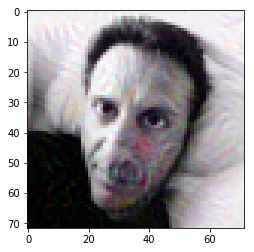

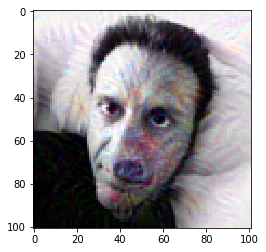

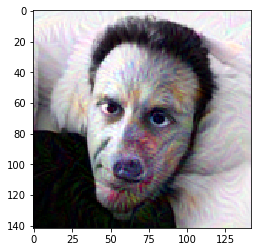

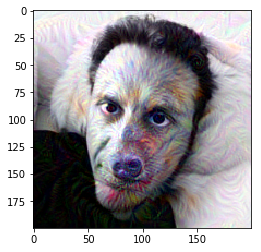

In [12]:
#Step 4 - Apply gradient ascent to that layer
render_deepdream(tf.square(T('mixed4c')) , img0, iter_n=10)

In [9]:
def render_naive(t_obj, img0=img_noise, iter_n=20, step=1.0):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
        
    img = img0.copy()
    for _ in range(iter_n):
        g, _ = sess.run([t_grad, t_score], {t_input:img})
        # normalizing the gradient, so the same step size should work 
        g /= g.std()+1e-8         # for different layers and networks
        img += g*step
    showarray(visstd(img))

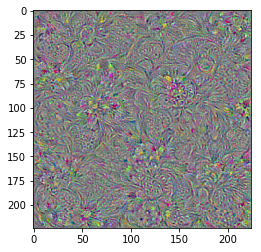

In [10]:
render_naive(T(layer)[:,:,:,channel])